# 데이터 기초 분석

공정 조건과 물성치 간의 대략적인 추세를 살펴보자.

## 데이터 읽기

- 특정 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 불러오기
- 2022-07-11 현재 json 포맷으로 정리되지 않은 정보 존재


In [1]:
import os
import json
from datetime import datetime
import pandas as pd
import numpy as np

import env

In [2]:
data_dir = os.path.join(r"F:\300장비", '7.sus_45_2circle_process', 'jsonsort')

data_dir

'F:\\300장비\\7.sus_45_2circle_process\\jsonsort'

In [3]:
!dir "$data_dir\\laseroffset"

 F 드라이브의 볼륨: Extreme Pro
 볼륨 일련 번호: 1230-10DD

 F:\300장비\7.sus_45_2circle_process\jsonsort\laseroffset 디렉터리

2022-07-05  오후 08:57    <DIR>          .
2022-07-05  오후 08:57    <DIR>          ..
2022-07-05  오후 08:57    <DIR>          0
2022-07-05  오후 08:57    <DIR>          1
2022-07-05  오후 08:57    <DIR>          10
2022-07-05  오후 08:57    <DIR>          11
2022-07-05  오후 08:57    <DIR>          12
2022-07-05  오후 08:57    <DIR>          13
2022-07-05  오후 08:57    <DIR>          14
2022-07-05  오후 08:57    <DIR>          15
2022-07-05  오후 08:57    <DIR>          2
2022-07-05  오후 08:57    <DIR>          3
2022-07-05  오후 08:57    <DIR>          4
2022-07-05  오후 08:57    <DIR>          5
2022-07-05  오후 08:57    <DIR>          6
2022-07-05  오후 08:57    <DIR>          7
2022-07-05  오후 08:57    <DIR>          8
2022-07-05  오후 08:57    <DIR>          9
               0개 파일                   0 바이트
              18개 디렉터리  50,766,807,040 바이트 남음


In [4]:
!dir "$data_dir\\sub"

 F 드라이브의 볼륨: Extreme Pro
 볼륨 일련 번호: 1230-10DD

 F:\300장비\7.sus_45_2circle_process\jsonsort\sub 디렉터리

2022-07-05  오후 08:57    <DIR>          .
2022-07-05  오후 08:57    <DIR>          ..
2022-06-29  오후 02:56                78 1.txt
2022-06-29  오후 03:00                79 10.txt
2022-06-29  오후 03:01                79 11.txt
2022-06-29  오후 03:01                78 12.txt
2022-06-29  오후 03:02                77 13.txt
2022-06-29  오후 03:02                79 14.txt
2022-06-29  오후 03:02                79 15.txt
2022-06-29  오후 03:03                78 16.txt
2022-06-29  오후 02:57                78 2.txt
2022-06-29  오후 02:57                79 3.txt
2022-06-29  오후 02:57                79 4.txt
2022-06-29  오후 02:58                79 5.txt
2022-06-29  오후 02:58                79 6.txt
2022-06-29  오후 02:59                79 7.txt
2022-06-29  오후 02:59                79 8.txt
2022-06-29  오후 02:59                79 9.txt
              16개 파일               1,258 바이트
               2개 디렉터리  50,766,807,040 바이트 남

In [5]:
sample_id_list = [int(i) for i in os.listdir(os.path.join(data_dir, 'laseroffset'))]
sample_id_list

[0, 1, 10, 11, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
%%time

data = {}
for sample_id in sample_id_list:
    
    fname_laser_cond = os.path.join(data_dir, 'laseroffset', str(sample_id), 'laseroffset.txt')
    with open(fname_laser_cond) as f:
        lines = f.readlines()
    
    laser_cond = {k:v for k, v in [s.strip().split(':') for s in lines]}
    
    with open(os.path.join(data_dir, 'sub', f'{sample_id+1}.txt'), encoding='utf-8-sig') as f:
        lines = f.readlines()
        
    prop = {k:v for k, v in [s.strip().split(':') for s in lines]}
    
    data[sample_id] = prop
    data[sample_id].update(laser_cond)

Wall time: 91.3 ms


In [7]:
data[2]

{'항복강도': '531.52MPa',
 '인장강도': '624.02MPa',
 '연신율': '30.8%',
 '밀도': '7.82',
 'power': '312',
 'speed': '1300'}

## 데이터 전처리

- 빈 칸 없애기, 단위 처리 등
- power 와 speed 가 반대로 기록


In [8]:
import re
re_num = re.compile(r'([0-9\.]+)(.*)')

In [9]:
# materials = ['SUS']
# facilities = ['Vulcan 300']

data_list = []
for i in range(16):
    _data = data[i]
    
    __data = {}
    for k, v in _data.items():
        if k == 'power':
            __data['laser_speed'] = float(v)     ## power 와 speed 가 반대로 기록
        elif k == 'speed':
            __data['laser_power'] = float(v)     ## power 와 speed 가 반대로 기록
        else:
            val, unit = re_num.match(v).groups()
            k = k if len(unit) == 0 else f'{k}({unit})'
            __data[k] = float(val)
    
    data_list.append(__data)

In [10]:
data_list[2]

{'항복강도(MPa)': 531.52,
 '인장강도(MPa)': 624.02,
 '연신율(%)': 30.8,
 '밀도': 7.82,
 'laser_speed': 312.0,
 'laser_power': 1300.0}

In [11]:
df = pd.DataFrame(data_list)
df['laser_density'] = df['laser_power'] / df['laser_speed']

print(data_dir)
df

F:\300장비\7.sus_45_2circle_process\jsonsort


,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_speed,laser_power,laser_density
0,524.73,529.91,5.8,7.81,264.0,1300.0,4.924242
1,499.44,514.07,3.8,7.82,360.0,1300.0,3.611111
2,531.52,624.02,30.8,7.82,312.0,1300.0,4.166667
3,550.15,636.87,23.1,7.80,408.0,1300.0,3.186275
4,539.46,628.42,30.8,7.82,264.0,1100.0,4.166667
5,548.77,644.49,40.4,7.87,360.0,1100.0,3.055556
6,548.38,641.99,42.3,7.82,312.0,1100.0,3.525641
7,557.55,652.86,42.3,7.78,408.0,1100.0,2.696078
8,551.02,646.73,42.3,7.80,264.0,900.0,3.409091
9,547.68,660.33,44.2,7.86,360.0,900.0,2.500000


# 데이터 분석

In [12]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams['font.family'] = 'Malgun Gothic'

def plot_annot(df_plot, x_col, y_cols, figsize=(24, 5)):
    
    fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    for i, c in enumerate(y_cols):
        x = df_plot[x_col]
        y = df_plot[c]
        ax[i].scatter(x, y)
        ax[i].set_title(c)
        ax[i].set_xlabel(x_col)

        for (_idx, _x, _y) in zip(x.index, x, y):
            ax[i].annotate(_idx, (_x, _y))

## 전체 데이터 분석

In [13]:
_idx = [True] * 16

# _idx[0] = False
# _idx[6] = False
# _idx[7] = False

# _idx[12] = False

df_corr = df.loc[_idx, :].corr()
df_corr

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_speed,laser_power,laser_density
항복강도(MPa),1.000000,0.877864,0.695302,-0.108373,2.246774e-01,-6.695632e-01,-0.657325
인장강도(MPa),0.877864,1.000000,0.907497,-0.050097,3.456457e-01,-5.654390e-01,-0.656815
연신율(%),0.695302,0.907497,1.000000,0.013530,3.091794e-01,-4.617820e-01,-0.545720
밀도,-0.108373,-0.050097,0.013530,1.000000,-3.748170e-01,-3.123475e-02,0.110760
laser_speed,0.224677,0.345646,0.309179,-0.374817,1.000000e+00,1.894781e-17,-0.580889
laser_power,-0.669563,-0.565439,-0.461782,-0.031235,1.894781e-17,1.000000e+00,0.799844
laser_density,-0.657325,-0.656815,-0.545720,0.110760,-5.808888e-01,7.998438e-01,1.000000


### 공정변수 vs 기계적 특성치 분포

In [14]:
y_cols = df.columns[:4].tolist()
df_plot = df.loc[_idx, :]

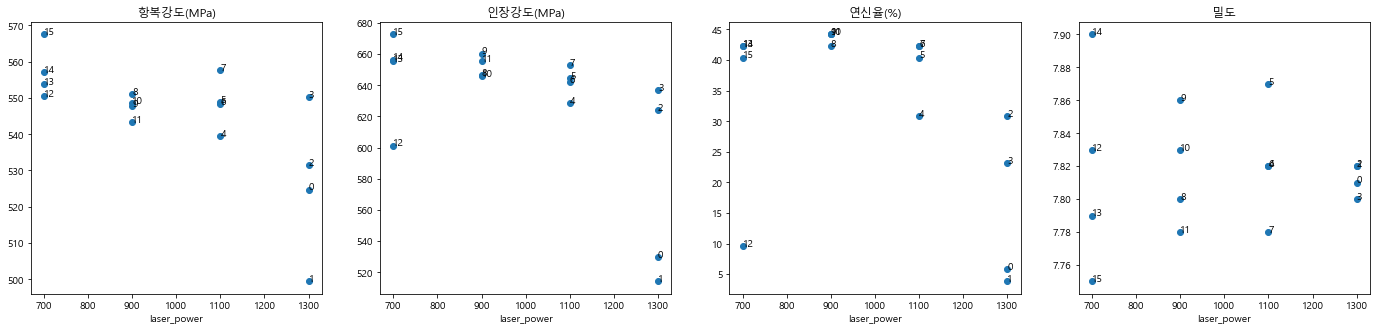

In [15]:
plot_annot(df_plot, 'laser_power', y_cols)

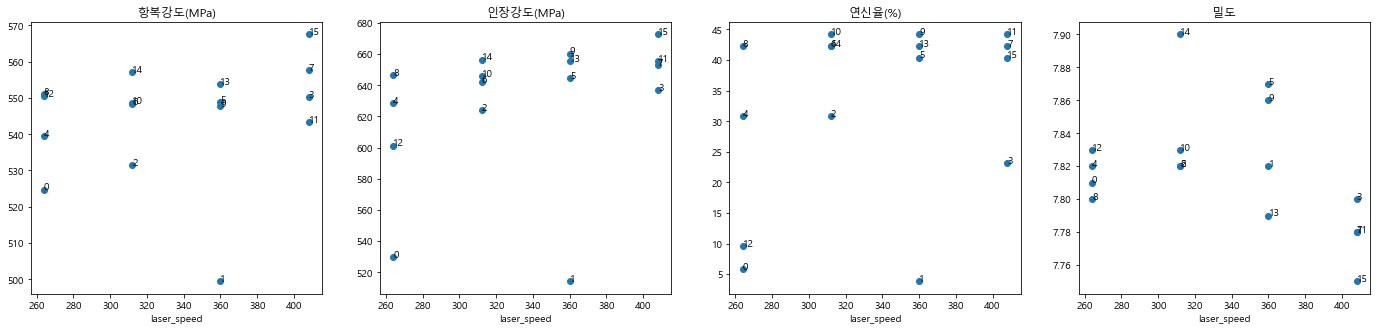

In [16]:
plot_annot(df_plot, 'laser_speed', y_cols)

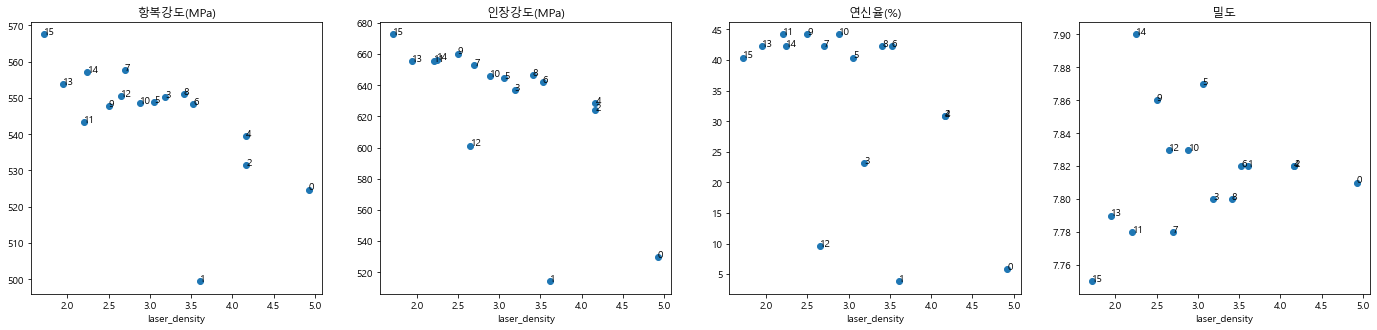

In [17]:
plot_annot(df_plot, 'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

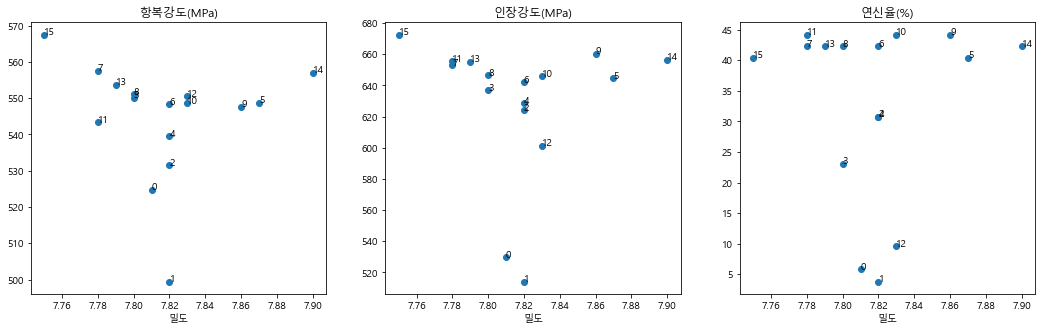

In [18]:
y_cols = df.columns[:3].tolist()

plot_annot(df_plot, '밀도', y_cols, figsize=(18, 5))

## 이상치 제외 데이터 분석 (1, 12 번 제외)

In [19]:
_idx = [True] * 16

_idx[1] = False
_idx[12] = False

df_corr = df.loc[_idx, :].corr()
df_corr

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_speed,laser_power,laser_density
항복강도(MPa),1.000000,0.812145,0.675240,-0.155384,0.552714,-0.694295,-0.839669
인장강도(MPa),0.812145,1.000000,0.900063,-0.026519,0.538637,-0.644303,-0.823576
연신율(%),0.675240,0.900063,1.000000,0.094372,0.324151,-0.690849,-0.737569
밀도,-0.155384,-0.026519,0.094372,1.000000,-0.372071,-0.008909,0.120904
laser_speed,0.552714,0.538637,0.324151,-0.372071,1.000000,-0.182526,-0.697761
laser_power,-0.694295,-0.644303,-0.690849,-0.008909,-0.182526,1.000000,0.818327
laser_density,-0.839669,-0.823576,-0.737569,0.120904,-0.697761,0.818327,1.000000


### 공정변수 vs 기계적 특성치 분포

In [20]:
y_cols = df.columns[:4].tolist()
df_plot = df.loc[_idx, :]

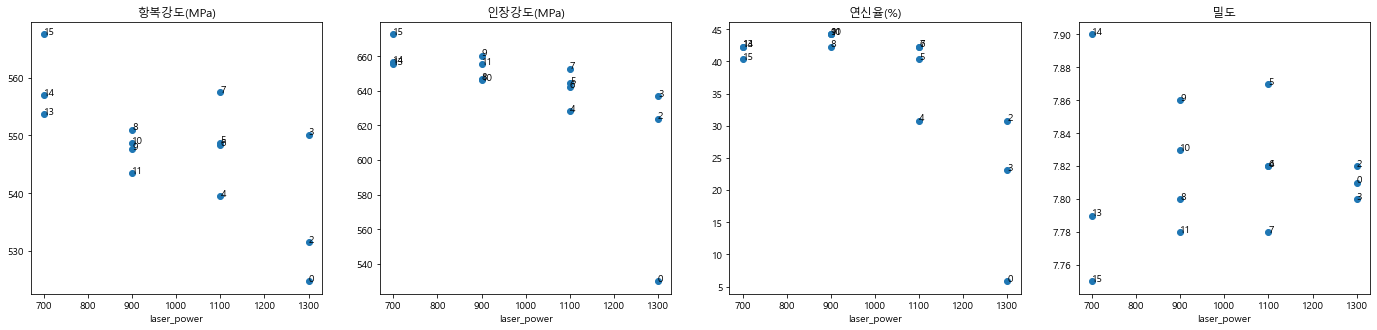

In [21]:
plot_annot(df_plot, 'laser_power', y_cols)

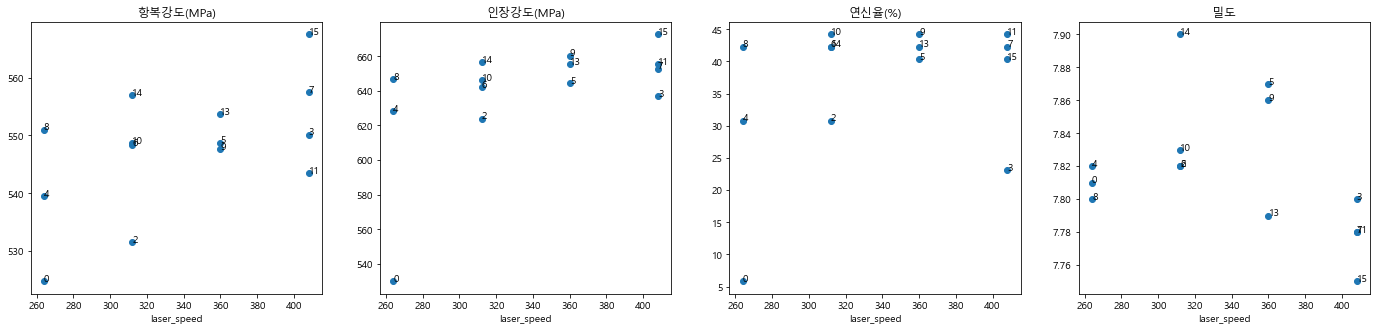

In [22]:
plot_annot(df_plot, 'laser_speed', y_cols)

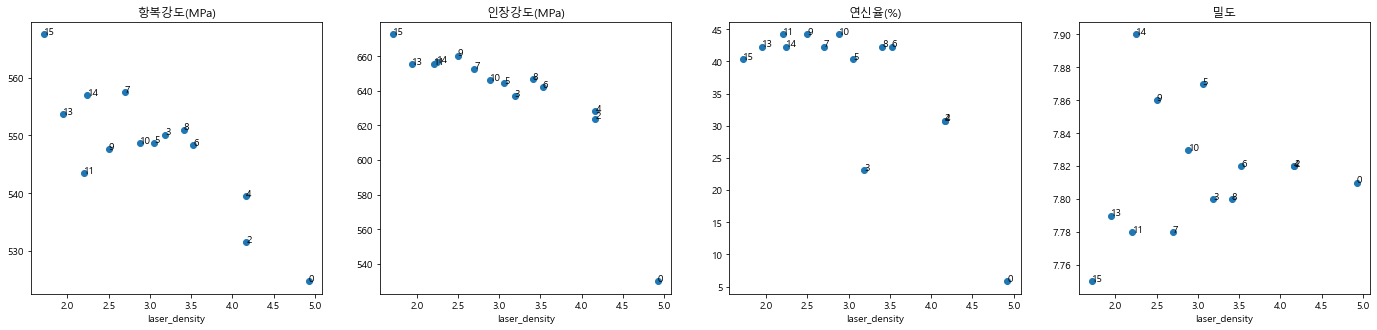

In [23]:
plot_annot(df_plot, 'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

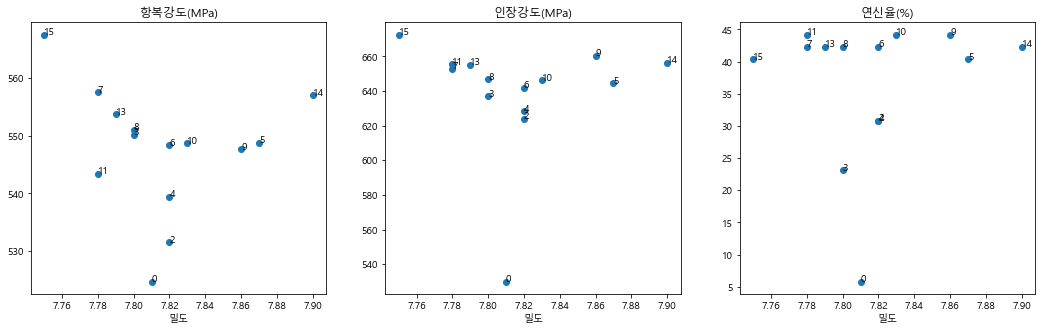

In [24]:
y_cols = df.columns[:3].tolist()

plot_annot(df_plot, '밀도', y_cols, figsize=(18, 5))